# **Basic Multi Agent**

### **``Import the required packages``**

In [1]:
# Import equired packages
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

### **``Define a state schema.``**

In [2]:
# We will use a schema of type TypedDict. Create a class called MyGraphState with two variables. count of datatype int and msg of datatype str.

# Create the structure of the schema for the graph.
class MyGraphState(TypedDict):
  count: int
  msg: str

### **``Define nodes``**

In [4]:
# We will define a function that will be used in multiple nodes in this graph.

# Define your node
def counter(state: MyGraphState):
  state["count"] += 1
  state["msg"] = f"Counter function has been called {state['count']} time(s)"
  return state

### **``Create a graph instance of StateGraph``**

In [5]:
# Create an instance of StateGraph with the structure of MyGraphState
workflow = StateGraph(MyGraphState)

### **``Add nodes to Graph``**

In [6]:
# Add three nodes to the workflow which are replicas of "counter"
workflow.add_node("Node1", counter)
workflow.add_node("Node2", counter)
workflow.add_node("Node3", counter)

### **``Add edges to the graph``**

In [7]:
# Add the nodes one after another. 
# All the Nodes in the workflow take state as input, update the state and pass it to the next Node as input.
# Output of Node1 goes to Node2 as input. Output of Node2 goes to Node3 as input.
workflow.add_edge(START, "Node1")
workflow.add_edge("Node1", "Node2")
workflow.add_edge("Node2", "Node3")

workflow.add_edge("Node3", END)

### **``Compile the graph``**

In [8]:
# Compile the workflow
app = workflow.compile()

### **``Visualize the graph``**

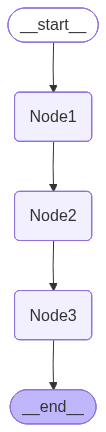

In [9]:
# Visualize your graph
from IPython.display import Image, display
png = app.get_graph().draw_mermaid_png()

display(Image(png))

### **``Test your graph``**

In [10]:
app.invoke({"count": 0, "msg":"hello"})

{'count': 3, 'msg': 'Counter function has been called 3 time(s)'}

# **Wand AI Multi Agent**

### **``Import the required packages``**

In [42]:
# Import equired packages
import os
import io
import re
import pandas as pd
from uuid import uuid4
from datetime import datetime
import matplotlib.pyplot as plt
from typing import Annotated, Optional
from langchain_core.tools import tool
from typing_extensions import TypedDict
from langgraph.prebuilt import ToolNode
from langchain_tavily import TavilySearch
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, ToolMessage

### **``Environment variables setup``**

In [ ]:
os.environ["GOOGLE_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""
os.environ["ANTHROPIC_API_KEY"] = ""

### **``LLM setup``**

In [44]:
# You can add temperature/other kwargs if you like.
# llm = init_chat_model("google_genai:gemini-2.5-flash")

llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")

### **``Define a state schema.``**

In [45]:
class MyGraphState(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)

    ## “a list of anything” (effectively list[Any]). Type checkers can’t help you much, and IDE autocomplete is weaker.
    # messages: Annotated[list, add_messages]

    ## “A list of LangChain message objects” (e.g., HumanMessage, AIMessage, SystemMessage, ToolMessage, …). This matches what LangGraph/ToolNode actually pass around, including .tool_calls on AIMessage.
    messages: Annotated[list[AnyMessage], add_messages]

    # Mode controls how far the pipeline runs: "research", "summary", "visualize", "full"
    mode: str

    # If user supplied a table as raw text for visualization
    table_text: str

### **```Tools```**

##### **```Tools # 1: Web Search```**

In [46]:
@tool
def web_search(user_input: str) -> str:
    """
    Return stitched text result from Tavily (string).
    """
    ts = TavilySearch(max_results=2)
    resp = ts.invoke({"query": user_input})
    chunks = [r.get("content") for r in resp.get("results", []) if r.get("content")]
    return "\n\n".join(chunks) or "No results found."

##### **```Tools # 2: Plot Visualization```**

In [47]:
@tool
def plot_table(table_text: str, chart_type: str = "line") -> str:
    """
    Parse table_text into a DataFrame, plot it, save PNG, and return file path.
    Accepts CSV or markdown-style table or whitespace-separated table.
    """

    txt = (table_text or "").strip()
    if not txt:
        raise ValueError("plot_table: table_text is empty")

    df = None
    # 1) markdown pipe table
    try:
        if '|' in txt and re.search(r'\|[-\s:]+\|', txt):
            # remove separator line and outer pipes, keep header + rows
            lines = []
            for line in txt.splitlines():
                if re.match(r'^\s*\|?\s*-{2,}\s*\|?', line):
                    continue
                lines.append(line.strip().strip('|'))
            csv_txt = "\n".join(lines)
            df = pd.read_csv(io.StringIO(csv_txt))
        # 2) plain CSV
        elif '\n' in txt and ',' in txt:
            df = pd.read_csv(io.StringIO(txt))
    except Exception:
        df = None

    # 3) whitespace separated
    if df is None:
        try:
            df = pd.read_csv(io.StringIO(txt), sep=r'\s+')
        except Exception:
            df = None

    if df is None:
        raise ValueError("plot_table: Unable to parse table_text into a DataFrame. Provide CSV or markdown table with header row.")

    # Choose x and y
    x_col = None
    for c in df.columns:
        if c.lower() in ("date", "year", "time") or re.search(r'date|year|time', c.lower()):
            x_col = c
            break
    if x_col is None:
        x_col = df.columns[0]

    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != x_col]
    y_col = numeric_cols[0] if numeric_cols else (df.columns[1] if len(df.columns) > 1 else None)
    if y_col is None:
        # try convert second column to numeric
        if len(df.columns) >= 2:
            try:
                df[df.columns[1]] = pd.to_numeric(df[df.columns[1]], errors='coerce')
                y_col = df.columns[1]
            except Exception:
                y_col = None

    if y_col is None:
        raise ValueError("plot_table: No numeric column found to plot. Provide at least one numeric column.")

    # attempt date parse for x
    try:
        df[x_col] = pd.to_datetime(df[x_col], errors='ignore')
    except Exception:
        pass

    # Plot
    plt.figure(figsize=(8, 4.5))
    if chart_type == "line":
        plt.plot(df[x_col], df[y_col], marker='o')
    elif chart_type == "bar":
        plt.bar(df[x_col].astype(str), df[y_col])
    elif chart_type == "scatter":
        plt.scatter(df[x_col], df[y_col])
    else:
        raise ValueError(f"plot_table: Unsupported chart_type: {chart_type}")

    plt.title(f"{y_col} vs {x_col}")
    plt.xlabel(str(x_col))
    plt.ylabel(str(y_col))
    plt.tight_layout()

    out_dir = "/mnt/data"
    os.makedirs(out_dir, exist_ok=True)
    fname = f"plot_{datetime.utcnow().strftime('%Y%m%d%H%M%S')}_{uuid4().hex[:6]}.png"
    out_path = os.path.join(out_dir, fname)
    plt.savefig(out_path, dpi=150)
    plt.close()

    return out_path

In [48]:
# In simple words bind tools restrict agents from calling any tool they want. tools_node has access to both tools and its python function or tool executor.

# Helpful Analogy:
   # Shop shelves = ToolNode → has both eggs and bread available (all tools that can be executed).
   # Person A = Researcher Agent (bind_tools([bread])) → is only told about bread.
   # Person B = Visualizer Agent (bind_tools([eggs])) → is only told about eggs.
        # If Person A (Researcher) tries to ask for eggs (plot_table), the model won't even think about eggs most of the time — because it doesn't know that eggs exist.
        # If, somehow, Person A misbehaves and asks for eggs anyway (rare, but LLMs can hallucinate), the ToolNode still has eggs and would hand them over (because it's stocked with everything).


# We need both binding and ToolNode.
# Bind_tools tells the model (LLM runnable) what tools it is allowed to call and what their argument 
# schema looks like. It’s a model-side permission and spec.

## Clarification: LangChain automatically injects those tool specs into the system prompt / OpenAI function-calling schema.
        ## The LLM now knows:
                ## Tool names
                ## Input parameters & types
                ## Tool descriptions (from decorators / docstrings)

## Researcher should only be able to call web_search
researcher_llm = llm.bind_tools([web_search])
## Visualizer should only be able to call plot_table
visualizer_llm = llm.bind_tools([plot_table])

# ToolNode (or your custom tool-executor) actually runs the Python function when the model emits a tool 
# call. It’s a runtime executor.
## ToolNode knows how to run either tool when asked
tools_node = ToolNode([web_search, plot_table])

### **```Prompts per agent```**

In [49]:
# Prompts per agent

planner_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are the Planner. Read the user request and produce a short plan (2–6 numbered steps). Indicate missing information as 1–3 direct questions. Do NOT call tools. Keep each step ≤ 20 words."),
    MessagesPlaceholder("messages"),
])

researcher_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are the Researcher. Gather reliable facts and short evidence fragments, then synthesize. "
     "If external info is needed, call tool web_search with an argument like {{\"user_input\": \"EV adoption Pakistan 2023 statistics\"}}. "
     "After any tool use, include up to 3 quoted evidence snippets (≤25 words each) with a 1-line source label, then a 2–4 sentence synthesis with provenance when possible. Keep output ≤220 words."),
    MessagesPlaceholder("messages"),
])

summarizer_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are the Summarizer. Produce 4–6 bullet points. Each bullet should start with a bold one-line header (e.g., **Key finding:**) followed by 1–2 sentences. Add one action-item bullet at the end (who does what next). Keep total ≤180 words."),
    MessagesPlaceholder("messages"),
])

visualizer_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are the Visualizer. If table_text is present or a table exists in the messages, propose a chart spec (title, x_col, y_col, chart_type). "
     "Then either call the tool plot_table with arguments like {{\"table_text\": \"<CSV or markdown table>\", \"chart_type\": \"line\"}} to draw it, "
     "OR return a JSON spec in the exact format {{\"action\":\"spec_only\",\"chart_type\":\"line\",\"title\":\"EV adoption\",\"x_col\":\"year\",\"y_col\":\"ev_count\",\"notes\":\"...\"}}. "
     "If you call plot_table, include a 1-line rationale for the choice. Keep text concise."),
    MessagesPlaceholder("messages"),
])

In [50]:
# Runnables
## Passing prompts to LLM to create runnables
## Docstrings/descriptions of bound tools directly shape the LLM’s reasoning about what it can call.

planner_runnable    = planner_prompt    | llm
researcher_runnable = researcher_prompt | researcher_llm
summarizer_runnable = summarizer_prompt | llm
visualizer_runnable = visualizer_prompt | visualizer_llm

### **``Define nodes``**

In [60]:
# Node implementations
## Function that will be triggered in each node.

## Clarification: Regarding whether we need to put docstrings like we do when we bind tools with llms or not and to answer that question ->
    ## Those are graph nodes (Python callables) inside LangGraph. They are not exposed as tools to the LLM.
    ## Instead, you wrap them in prompts (ChatPromptTemplate) where you provide the system message like:

def planner_agent(state: MyGraphState):
    ai = planner_runnable.invoke(state)
    return {"messages": [ai]}

def researcher_agent(state: MyGraphState):
    ai = researcher_runnable.invoke(state)
    return {"messages": [ai]}

def summarizer_agent(state: MyGraphState):
    ai = summarizer_runnable.invoke(state)
    return {"messages": [ai]}

def visualizer_agent(state: MyGraphState):
    """
    Run the visualizer LLM. If it emits a tool call, we return the AIMessage
    and let the ToolNode run the tool in the next graph step. If it emits no
    tool call but table_text exists, auto-invoke plot_table here.
    """
    ai = visualizer_runnable.invoke(state)
    # If the model already requested a tool, return only the AIMessage.
    # The graph's conditional routing should send us to the ToolNode next.
    tool_calls = getattr(ai, "tool_calls", None)
    if tool_calls and len(tool_calls) > 0:
        # Do NOT auto-run the tool here — ToolNode will run it next.
        return {"messages": [ai]}

    # No tool call present. If table_text exists, auto-plot.
    out_messages = [ai]
    if state.get("table_text"):
        try:
            chart_type = "line"
            content_lower = (ai.content or "").lower()
            if "bar chart" in content_lower or ("bar" in content_lower and "line" not in content_lower):
                chart_type = "bar"
            elif "scatter" in content_lower:
                chart_type = "scatter"

            file_path = plot_table.invoke(state["table_text"], chart_type)
            # Return a ToolMessage so downstream consumers see the tool result
            tm = ToolMessage(tool_call_id=str(uuid4()), name="plot_table", content=file_path)
            out_messages.append(tm)

            # Optionally add a follow-up AIMessage (safe since there was no tool_use)
            follow_up = AIMessage(content=f"Automatically plotted table as a {chart_type} chart. File saved at: {file_path}")
            out_messages.append(follow_up)
        except Exception as e:
            out_messages.append(AIMessage(content=f"Failed to auto-plot the table: {e}"))

    return {"messages": out_messages}


### **``Edge conditions``**

In [61]:
# Router logic (mode-driven) OR Edge conditions

def route_from_researcher(state: MyGraphState):
    mode = state.get("mode", "full")
    last = state["messages"][-1]
    if hasattr(last, "tool_calls") and last.tool_calls:
        return "tools"
    if mode == "research":
        return END
    return "summarizer_agent"

def route_from_summarizer(state: MyGraphState):
    mode = state.get("mode", "full")
    last = state["messages"][-1]
    if hasattr(last, "tool_calls") and last.tool_calls:
        return "tools"
    if mode == "summary":
        return END
    return "visualizer_agent"

def route_from_visualizer(state: MyGraphState):
    last = state["messages"][-1]
    if hasattr(last, "tool_calls") and last.tool_calls:
        return "tools"
    # if mode is visualize, stop after visualizer; else continue to END
    mode = state.get("mode", "full")
    if mode == "visualize":
        return END
    return END

### **``Create a graph instance of StateGraph``**

In [62]:
# Create an instance of StateGraph with the structure of MyGraphState
workflow = StateGraph(MyGraphState)

### **``Add nodes to Graph``**

In [63]:
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
workflow.add_node("planner_agent",    planner_agent)   
workflow.add_node("researcher_agent", researcher_agent)
workflow.add_node("summarizer_agent", summarizer_agent)
workflow.add_node("visualizer_agent", visualizer_agent)
workflow.add_node("tools",            tools_node)

### **``Add edges to the graph``**

In [64]:
# Add the nodes one after another. 
# All the Nodes in the workflow take state as input, update the state and pass it to the next Node as input.
# Output of Node1 goes to Node2 as input. Output of Node2 goes to Node3 as input.
workflow.add_edge(START, "planner_agent")
workflow.add_edge("planner_agent", "researcher_agent")

workflow.add_conditional_edges("researcher_agent", route_from_researcher,
                               {"tools": "tools", "summarizer_agent": "summarizer_agent", str(END): str(END)})

# tools -> back to researcher (research loop)
workflow.add_edge("tools", "researcher_agent")


# Information regarding how conditional edges work:
## workflow.add_conditional_edges(from_node, condition_fn, mapping)
    # This means:
    # When the graph finishes running from_node, call condition_fn(state). Based on its return value, go to the mapped next node.
workflow.add_conditional_edges("summarizer_agent", route_from_summarizer,
                               {"visualizer_agent": "visualizer_agent", str(END): str(END)})

# allow visualizer to call tools and loop back to itself
workflow.add_conditional_edges("visualizer_agent", route_from_visualizer,
                               {"tools": "tools", str(END): str(END)})
workflow.add_edge("tools", "visualizer_agent")

workflow.add_edge("visualizer_agent", END)

### **``Compile the graph``**

In [65]:
# Compile the workflow
app = workflow.compile()

In [66]:
# Helpers Functions

from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

def _flatten_messages(raw_messages):
    """Yield message objects in a flat sequence from possibly nested lists."""
    stack = list(raw_messages)
    while stack:
        m = stack.pop(0)
        if m is None:
            continue
        if isinstance(m, (list, tuple)):
            stack = list(m) + stack
            continue
        yield m

def last_nonempty_ai_message(messages):
    """
    Find last AIMessage with non-empty textual content.
    Handles nested lists and ToolMessage content that might be non-string.
    """
    last_found = None
    for m in _flatten_messages(messages):
        # Debugging: print unexpected types (optional)
        if not isinstance(m, (AIMessage, ToolMessage, HumanMessage)):
            # You can log this instead of printing in production
            # print("DEBUG: unexpected message type:", type(m), m)
            pass

        if isinstance(m, AIMessage):
            content = m.content or ""
            if isinstance(content, (list, tuple)):
                # flatten if AIMessage.content is a list of strings
                text = " ".join(str(x) for x in content if x)
            else:
                text = str(content)
            if text.strip():
                last_found = m

        # Sometimes tools return their result as ToolMessage.content (string or other)
        # but we only want AIMessage textual syntheses here.

    return last_found


def try_draw_graph(app):
    try:
        png = app.get_graph().draw_mermaid_png()
        from IPython.display import Image, display
        display(Image(png))
    except Exception:
        pass

### **``Visualize the graph``**

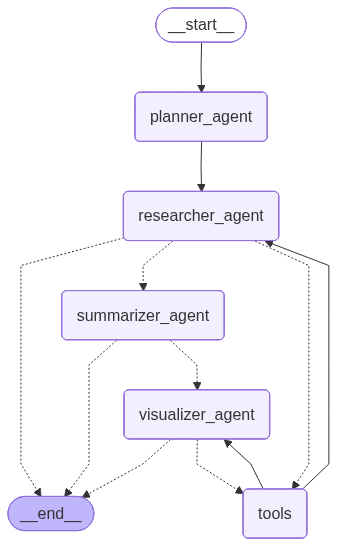

In [67]:
# Visualize your graph
from IPython.display import Image, display
png = app.get_graph().draw_mermaid_png()

display(Image(png))

### **``Test your graph``**

In [68]:
import os
import time
from langchain_core.messages import HumanMessage, ToolMessage

# ---------------------------
# Example runs
# ---------------------------
if __name__ == "__main__":
    # Quick env check
    if not os.environ.get("TAVILY_API_KEY"):
        print("WARNING: TAVILY_API_KEY missing in environment (set it to run web_search).")

    # Example 1: research-only
    inputs = {
        "messages": [HumanMessage(content="Find 2 recent stats on EV adoption in Pakistan and summarize.")],
        "mode": "research"
    }
    out = app.invoke(inputs)
    print("\n--- Research-only final ---")
    final = last_nonempty_ai_message(out["messages"])
    print(final.content if final else "(no non-empty AI message)")

    time.sleep(2)  # <-- delay between runs

    # Example 2: summary-only
    inputs2 = {
        "messages": [HumanMessage(content="Find 2 recent stats on EV adoption in Pakistan and summarize.")],
        "mode": "summary"
    }
    out2 = app.invoke(inputs2)
    print("\n--- Summary-only final ---")
    final2 = last_nonempty_ai_message(out2["messages"])
    print(final2.content if final2 else "(no non-empty AI message)")

    time.sleep(2)  # <-- delay between runs

    # Example 3: visualize with CSV provided
    csv_text = "year,ev_count\n2018,1000\n2019,3000\n2020,7000\n2021,15000\n2022,23000\n"
    inputs3 = {
        "messages": [HumanMessage(content="Please visualize the table below.\n\n" + csv_text)],
        "mode": "visualize",
        "table_text": csv_text
    }
    out3 = app.invoke(inputs3)
    print("\n--- Visualize final ---")
    final3 = last_nonempty_ai_message(out3["messages"])
    print(final3.content if final3 else "(no non-empty AI message)")

    # Look for produced ToolMessage(s) with plot output
    for m in out3["messages"]:
        if isinstance(m, ToolMessage) and getattr(m, "name", "") == "plot_table":
            print("Plot produced at:", getattr(m, "content", None))


BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.3: `tool_use` ids were found without `tool_result` blocks immediately after: toolu_01Ep7TBQQyVwAwE8NXdXdrVj. Each `tool_use` block must have a corresponding `tool_result` block in the next message.'}, 'request_id': 'req_011CTfZifeSTbDcQykKN36tu'}